# Time series representation and analysis

The [astropy.timeseries](http://docs.astropy.org/en/stable/timeseries/index.html) sub-package is a relatively new component of astropy which provides a framework for representing time series, and includes some initial analysis tools (but this is expected to grow over time).


<section class="objectives panel panel-warning">
<div class="panel-heading">
<h2><span class="fa fa-certificate"></span> Objectives</h2>
</div>


<div class="panel-body">

<ul>
<li>Create time series</li>
<li>Access data and times</li>
<li>Relative time series</li>
<li>Combining time series</li>
<li>Sorting time series</li>
<li>Folding time series</li>
<li>Periodogram analysis</li>
<li>Reading in data</li>
</ul>

</div>

</section>


## Documentation

This notebook only shows a subset of the functionality in astropy.timeseries. For more information about the features presented below as well as other available features, you can read the
[astropy.timeseries documentation](https://docs.astropy.org/en/stable/timeseries/).

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('image', origin='lower')
plt.rc('figure', figsize=(10, 6))

## Creating time series

The astropy.timeseries sub-package provides two main classes for representing time series, both of which are sub-classes of [QTable](http://docs.astropy.org/en/stable/api/astropy.table.QTable.html#astropy.table.QTable):

* [TimeSeries](http://docs.astropy.org/en/stable/api/astropy.timeseries.TimeSeries.html#astropy.timeseries.TimeSeries) to represent a series of measurements at different (and exact) times
* [BinnedTimeSeries](http://docs.astropy.org/en/stable/api/astropy.timeseries.BinnedTimeSeries.html#astropy.timeseries.BinnedTimeSeries), to represent a series of measurements in different time bins.

In most cases, [TimeSeries](http://docs.astropy.org/en/stable/api/astropy.timeseries.TimeSeries.html#astropy.timeseries.TimeSeries) might be enough unless you need to treat the finite bin sizes carefully (as for example in X-ray analysis). In this tutorial we will focus on TimeSeries, but if you are interested in representing binned time series, you can take a look at the [astropy.timeseries documentation](http://docs.astropy.org/en/stable/timeseries/index.html).

Let's start off by creating a synthetic time series, and we will look later into how to read existing files.

In [1]:
from astropy.timeseries import TimeSeries

There are several ways to initialize a time series from scratch. One of the easiest ways if you are dealing with a regularly spaced time series is to specify the start time, the time between samples, and the number of samples:

In [2]:
from astropy import units as u
ts1 = TimeSeries(time_start="2016-03-22T12:30:31", time_delta=3*u.s, n_samples=5)
ts1

time
object
2016-03-22T12:30:31.000
2016-03-22T12:30:34.000
2016-03-22T12:30:37.000
2016-03-22T12:30:40.000
2016-03-22T12:30:43.000


Another way is to specify the times at which the measurements were made:

In [4]:
ts2 = TimeSeries(time=["2016-03-22T12:35:31", "2016-03-22T12:40:31", "2016-03-22T12:45:31"])
ts2

time
object
2016-03-22T12:35:31.000
2016-03-22T12:40:31.000
2016-03-22T12:45:31.000


In the above cases, we just passed strings to the ``time=`` option, but this is actually a shortcut - the most general way to create the time series which provides the most control is to pass a Time object (from astropy.time):

In [6]:
import numpy as np
from astropy.time import Time
time = Time(np.linspace(50000, 51000, 6), format="mjd", scale="tdb")
ts3 = TimeSeries(time=time)
ts3

time
object
50000.0
50200.0
50400.0
50600.0
50800.0
51000.0


Once the time series has been initialized, you can add columns to it as if it was a table:

In [9]:
ts3['flux'] = [1, 2, 3, 4, 5, 6] * u.mJy
ts3["error"] = [0.1, 0.2, 0.1, 0.2, 0.1, 0.3] * u.mJy

## Accessing data and times

Data is accessed in the same way as for regular tables:

In [10]:
ts3["time"]

<Time object: scale='tdb' format='mjd' value=[50000. 50200. 50400. 50600. 50800. 51000.]>

In [11]:
ts3["flux"]

<Quantity [1., 2., 3., 4., 5., 6.] mJy>

In [13]:
ts3["time", "flux"]

time,flux
,mJy
object,float64
50000.0,1.0
50200.0,2.0
50400.0,3.0
50600.0,4.0
50800.0,5.0
51000.0,6.0


In [14]:
ts3[0]

time,flux,error
,mJy,mJy
object,float64,float64
50000.0,1.0,0.1


In [15]:
ts3[0:3]

time,flux,error
,mJy,mJy
object,float64,float64
50000.0,1.0,0.1
50200.0,2.0,0.2
50400.0,3.0,0.1


In [16]:
ts3[0]["flux"]

<Quantity 1. mJy>

For the time column, it is also possible to use the following shortcut:

In [17]:
ts3.time

<Time object: scale='tdb' format='mjd' value=[50000. 50200. 50400. 50600. 50800. 51000.]>

Since this is a regular time object, you can convert it to different time scales and formats:

In [18]:
ts3.time.tai

<Time object: scale='tai' format='mjd' value=[49999.99962752 50199.99962748 50399.99962752 50599.99962749
 50799.99962751 50999.9996275 ]>

In [19]:
ts3.time.isot

array(['1995-10-10T00:00:00.000', '1996-04-27T00:00:00.000',
       '1996-11-13T00:00:00.000', '1997-06-01T00:00:00.000',
       '1997-12-18T00:00:00.000', '1998-07-06T00:00:00.000'], dtype='<U23')

Note that this doesn't change the time in the time series, it just returns a new Time object. On the other hand, you can change the default format by setting ``.format``:

In [26]:
ts3

time,flux,error
,mJy,mJy
object,float64,float64
50000.0,1.0,0.1
50200.0,2.0,0.2
50400.0,3.0,0.1
50600.0,4.0,0.2
50800.0,5.0,0.1
51000.0,6.0,0.3


In [27]:
ts3.time.format = "isot"

In [21]:
ts3

time,flux,error
,mJy,mJy
object,float64,float64
1995-10-10T00:00:00.000,1.0,0.1
1996-04-27T00:00:00.000,2.0,0.2
1996-11-13T00:00:00.000,3.0,0.1
1997-06-01T00:00:00.000,4.0,0.2
1997-12-18T00:00:00.000,5.0,0.1
1998-07-06T00:00:00.000,6.0,0.3


## Relative time series

If you want to work with relative time series, you can do the following:

In [32]:
from astropy.time import TimeDelta
ts4 = TimeSeries(time=TimeDelta([1, 3, 4]*u.s))
ts4

time
object
1.1574074074074073e-05
3.472222222222222e-05
4.6296296296296294e-05


and this can also be done by taking a time series in absolute times and subtracting a reference time:

In [29]:
ts5 = TimeSeries(time=ts3.time - ts3.time[0], data=ts3["flux", "error"])
ts5

time,flux,error
,mJy,mJy
object,float64,float64
0.0,1.0,0.1
200.0,2.0,0.2
400.0,3.0,0.1
600.0,4.0,0.2
800.0,5.0,0.1
1000.0,6.0,0.3


## Combining time series

Assuming that you have two time series objects with matching columns as well as another table which represents an additional column:

In [33]:
from astropy.table import Table

ts_a = TimeSeries(time_start='2016-03-22T12:30:31',
                  time_delta=3 * u.s,
                  data={'flux': [1, 4, 5, 3, 2] * u.mJy})

ts_b = TimeSeries(time_start='2016-03-22T12:50:31',
                  time_delta=3 * u.s,
                  data={'flux': [4, 3, 1, 2, 3] * u.mJy})

data = Table(data={'temperature': [40., 41., 40., 39., 30.] * u.K})

There are different ways of combining these - for example you can stack one of the time series with the additional data 'horizontally', which means you preserve the number of rows but construct a new time series with more columns:

In [35]:
from astropy.table import hstack, join, vstack

In [40]:
tsh = hstack([ts_a, data])
tsh

time,flux,temperature
,mJy,K
object,float64,float64
2016-03-22T12:30:31.000,1.0,40.0
2016-03-22T12:30:34.000,4.0,41.0
2016-03-22T12:30:37.000,5.0,40.0
2016-03-22T12:30:40.000,3.0,39.0
2016-03-22T12:30:43.000,2.0,30.0


or you can stack the time series 'vertically' meaning that the columns are preserved but we make a new time series with all the rows from the original two time series:

In [38]:
tsv = vstack([ts_a, ts_b])
tsv

time,flux
,mJy
object,float64
2016-03-22T12:30:31.000,1.0
2016-03-22T12:30:34.000,4.0
2016-03-22T12:30:37.000,5.0
2016-03-22T12:30:40.000,3.0
2016-03-22T12:30:43.000,2.0
2016-03-22T12:50:31.000,4.0
2016-03-22T12:50:34.000,3.0
2016-03-22T12:50:37.000,1.0


## Sorting

Since TimeSeries objects are just tables behind the hood, you can also sort them as you would a table:

In [42]:
tsv.sort("flux")
tsv

time,flux
,mJy
object,float64
2016-03-22T12:30:31.000,1.0
2016-03-22T12:50:37.000,1.0
2016-03-22T12:30:43.000,2.0
2016-03-22T12:50:40.000,2.0
2016-03-22T12:30:40.000,3.0
2016-03-22T12:50:34.000,3.0
2016-03-22T12:50:43.000,3.0
2016-03-22T12:30:34.000,4.0


## Folding

A common operation with time series is 'folding' by assuming a given period. Let's start off with a synthetic dataset:

In [46]:
ts_synth = TimeSeries(time_start='2019-01-01T00:00:00',
                      time_delta=np.random.uniform(0, 10, 1000) * u.min)
ts_synth['flux'] = np.cos(2 * np.pi * (ts_synth.time.mjd / 0.49822))
ts_synth['flux'] += np.random.normal(0, 0.2, 1000)

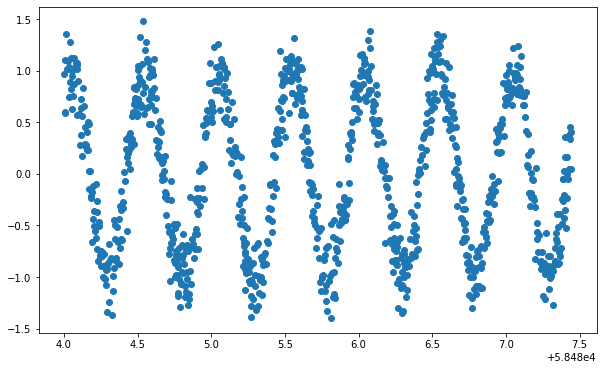

In [47]:
plt.plot(ts_synth.time.mjd, ts_synth['flux'], 'o')

Folding is done with the [TimeSeries.fold](http://docs.astropy.org/en/stable/api/astropy.timeseries.TimeSeries.html#astropy.timeseries.TimeSeries.fold) method:

In [49]:
folded = ts_synth.fold(period=0.49822*u.day)
folded

time,flux
object,float64
0.0,0.9714066749720852
0.004555756122930503,0.5850973753254061
0.006229251124332222,0.5955768298258403
0.01041977602096983,1.1064915960343336
0.01725856407971799,1.35224833531292
0.020748165062049743,1.0149820714422335
0.02739202492812448,1.0956065211191297
0.03243343628159622,0.742331837001651
0.037730927510272065,1.034923236446002


In [50]:
folded.time.to(u.day).value[:10]

array([0.        , 0.00455576, 0.00622925, 0.01041978, 0.01725856,
       0.02074817, 0.02739202, 0.03243344, 0.03773093, 0.03839745])

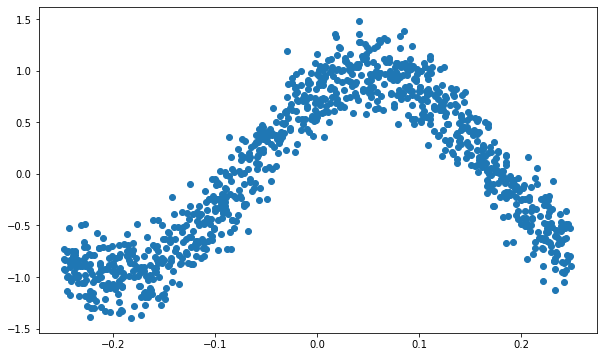

In [51]:
plt.plot(folded.time.to(u.day).value, ts_synth["flux"], "o")

## Periodogram analysis

In the above example it was clear what period to use since we generated the data, but how would we find the period in the first place if it wasn't known? The astropy.timeseries sub-package includes several algorithms for periodogram analysis, the most general one being the Lomb-Scargle algorithm ([Lomb 1976](http://adsabs.harvard.edu/abs/1976Ap%26SS..39..447L), [Scargle 1982](http://adsabs.harvard.edu/abs/1982ApJ...263..835S)). To use this, first create an instance of the [LombScargle](http://docs.astropy.org/en/stable/api/astropy.timeseries.LombScargle.html#astropy.timeseries.LombScargle) class:

In [52]:
from astropy.timeseries import LombScargle

In [53]:
ls = LombScargle.from_timeseries(ts_synth, "flux")

To run the periodogram analysis, the easiest way is to call the [autopower](http://docs.astropy.org/en/stable/api/astropy.timeseries.LombScargle.html#astropy.timeseries.LombScargle.autopower) method:

In [54]:
frequency, power = ls.autopower()

In [55]:
frequency

<Quantity [2.90470766e-02, 8.71412299e-02, 1.45235383e-01, ...,
           7.26089775e+02, 7.26147869e+02, 7.26205963e+02] 1 / d>

In [56]:
power

<Quantity [0.00387979, 0.00326655, 0.00211172, ..., 0.00233135, 0.00351351,
           0.00467587]>

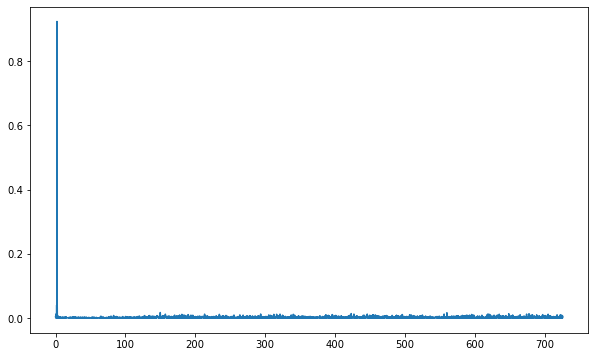

In [57]:
plt.plot(frequency, power)

We can zoom in on the low frequency peak by doing:

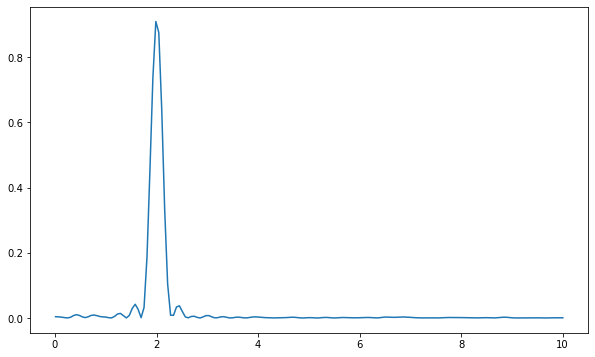

In [58]:
frequency, power = ls.autopower(minimum_frequency=0.01/u.day, maximum_frequency=10/u.day)
plt.plot(frequency, power)

The peak is located at:

In [59]:
peak = np.argmax(power)
frequency[peak]

<Quantity 1.98520121 1 / d>

In [60]:
1/frequency[peak]

<Quantity 0.50372728 d>

## Reading in data

Reading in time series can be done via the [TimeSeries.read](http://docs.astropy.org/en/stable/api/astropy.timeseries.TimeSeries.html#astropy.timeseries.TimeSeries.read) method. This accepts all the formats supported by the Table class, and requires that you specify the name of the time column, and optionally the format and scale for the time. We will take a look at this by reading a CSV file that looks like:

    Date,A,B,C,D,E,F,G
    2008-03-18,24.68,164.93,114.73,26.27,19.21,28.87,63.44
    2008-03-19,24.18,164.89,114.75,26.22,19.07,27.76,59.98
    ...
    
To read this file, you can do:

In [61]:
ts_file = TimeSeries.read("data/sampled.csv", format="ascii.csv", time_column="Date")
ts_file

time,A,B,C,D,E,F,G
object,float64,float64,float64,float64,float64,float64,float64
2008-03-18 00:00:00.000,24.68,164.93,114.73,26.27,19.21,28.87,63.44
2008-03-19 00:00:00.000,24.18,164.89,114.75,26.22,19.07,27.76,59.98
2008-03-20 00:00:00.000,23.99,164.63,115.04,25.78,19.01,27.04,59.61
2008-03-25 00:00:00.000,24.14,163.92,114.85,27.41,19.61,27.84,59.41
2008-03-26 00:00:00.000,24.44,163.45,114.84,26.86,19.53,28.02,60.09
2008-03-27 00:00:00.000,24.38,163.46,115.4,27.09,19.72,28.25,59.62
2008-03-28 00:00:00.000,24.32,163.22,115.56,27.13,19.63,28.24,58.65
2008-03-31 00:00:00.000,24.19,164.02,115.54,26.74,19.55,28.43,59.2
2008-04-01 00:00:00.000,23.81,163.59,115.72,27.82,20.21,29.17,56.18


For some well defined formats (e.g. Kepler/TESS time series files), it is enough to specify the filename.


<section class="challenge panel panel-success">
<div class="panel-heading">
<h2><span class="fa fa-pencil"></span> The Nobel Challenge (Part 1)</h2>
</div>


<div class="panel-body">

<p>This challenge is a little longer than previous ones, and it brings together several tutorials. The aim here is to start from a realistic dataset which consists of radial velocities of <a href="https://en.wikipedia.org/wiki/51_Pegasi">51 Peg</a> and go all the way through to finding a probability distribution for the companion mass. The starting point is a FITS binary table from <a href="http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=J/AJ/153/138">Birkby+ 2017 on Vizier</a>. The file can be found at <a href="data/birkby2017.fits">data/birkby2017.fits</a>.</p>
<ol>
<li>Start off by reading in the data into a TimeSeries object using TimeSeries.read as shown above. Since this table is not in a standard time series format, you will need to specify the name of the time column, and you will also need to specify the time format with <code>time_format</code>. See the <a href="http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=J/AJ/153/138">Vizier page</a> for more details about the available columns, and the documentation for <a href="http://docs.astropy.org/en/stable/api/astropy.timeseries.TimeSeries.html#astropy.timeseries.TimeSeries.read">TimeSeries.read</a> for details about the options to provide. If you want to be extra careful you can also try setting the time scale to the appropriate one based on what you can find on the Vizier page.</li>
<li>Make a plot of the time series. You'll probably notice that strangely the velocities seem to cluster around two main values, and this doesn't look very much like what you would expect. Read Note 2 on the <a href="http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=J/AJ/153/138">Vizier page</a> to find out what might be going on!</li>
<li>Modify the table so that all the velocities are on the same zero point, using standard table operations. Note that you will need to be careful here because the <code>Set</code> column which identifies each dataset/instrument is <em>always</em> 6 characters long and includes trailing spaces (i.e. <code>''HIRES '</code> not <code>'HIRES'</code>). Make a plot of the updated velocities to make sure things look more sensible.</li>
<li>Run a Lomb-Scargle periodogram analysis of the radial velocities to find whether the data has any periodicity. Note that you will probably have to zoom in a bit on the most promising peak to get a more accurate period.</li>
<li>Fold the time series using the period you found in the previous step, and plot the resulting radial velocity curve. If you got the right period, the resulting curve should look much simpler!</li>
</ol>

</div>

</section>



<section class="challenge panel panel-success">
<div class="panel-heading">
<h2><span class="fa fa-pencil"></span> The Nobel Challenge (Part 2)</h2>
</div>


<div class="panel-body">

<ol>
<li>Now use what we learned in the modeling tutorial to fit a sinusoid to the folded radial velocity curve, plot the fit, and determine the amplitude of the velocity. Note that you may need to adjust the initial parameters of the model (in particular the frequency) to get a good fit.</li>
<li>(optional) Try and extract the error in the amplitude from <code>fitter.fit_info</code>. The <code>param_cov</code> key gives the covariance matrix, and the parameters are in the order given by the <code>param_names</code> attribute on the model. Note also that this will not have units attached, but the units will be the same as the parameters. You can also skip this step and assume an error in the amplitude of 0.5 m/s if you prefer.</li>
</ol>
<p>The challenge will continue in the next tutorial!</p>

</div>

</section>


<center><i>This notebook was written by <a href="https://aperiosoftware.com/">Aperio Software Ltd.</a> &copy; 2019, and is licensed under a <a href="https://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License (CC BY 4.0)</a></i></center>

![cc](https://mirrors.creativecommons.org/presskit/buttons/88x31/svg/by.svg)